<a href="https://colab.research.google.com/github/finardi/IA376J/blob/master/Aula3_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Oct  5 03:14:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data

In [ ]:
!mkdir data
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/*_IMAGES_coco_5_cap_per_img.hdf5 data/.
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/*_CAPTIONS_coco_5_cap_per_img.json data/.

#-------------------------------------------------------------------------------------
train_path_captions = '/content/data/TRAIN_CAPTIONS_coco_5_cap_per_img.json'
train_path_imgs     = '/content/data/TRAIN_IMAGES_coco_5_cap_per_img.hdf5'

val_path_captions = '/content/data/VAL_CAPTIONS_coco_5_cap_per_img.json'
val_path_imgs     = '/content/data/VAL_IMAGES_coco_5_cap_per_img.hdf5'

test_path_captions = '/content/data/TEST_CAPTIONS_coco_5_cap_per_img.json'
test_path_imgs     = '/content/data/TEST_IMAGES_coco_5_cap_per_img.hdf5'

Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/TEST_IMAGES_coco_5_cap_per_img.hdf5...
Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/TRAIN_IMAGES_coco_5_cap_per_img.hdf5...
Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/VAL_IMAGES_coco_5_cap_per_img.hdf5...
- [3/3 files][  4.7 GiB/  4.7 GiB] 100% Done  13.7 MiB/s ETA 00:00:00           
Operation completed over 3 objects/4.7 GiB.                                      
Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/TEST_CAPTIONS_coco_5_cap_per_img.json...
Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/VAL_CAPTIONS_coco_5_cap_per_img.json...
Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/TRAIN_CAPTIONS_coco_5_cap_per_img.json...
/ [3/3 files][  6.8 MiB/  6.8 MiB] 100% Done                                    
Operation completed over 3 objects/6.8 MiB.                                      


# Import  e instação das bibliotecas

In [ ]:
! pip install -q einops
! pip install -q sacrebleu
! pip install -q transformers
! pip install -q efficientnet_pytorch

     |████████████████████████████████| 71kB 3.6MB/s 
     |████████████████████████████████| 1.1MB 5.2MB/s 
     |████████████████████████████████| 1.1MB 12.4MB/s 
     |████████████████████████████████| 3.0MB 20.6MB/s 
     |████████████████████████████████| 890kB 41.7MB/s 


In [ ]:
import gc
import math
import nltk
import h5py
import json
import torch
import pprint
import sacrebleu
import numpy as np
import pandas as pd
import torch.nn as nn
from einops import rearrange
from collections import Counter
import torch.nn.functional as F
from torchvision import transforms
import efficientnet_pytorch as efp
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerDecoder, TransformerDecoderLayer

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#================= Experimentos determnísticos e seeds =================#
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
manual_seed = 2711 

def deterministic(rep=True):
    if rep:
        np.random.seed(manual_seed)
        torch.manual_seed(manual_seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(manual_seed)
            torch.cuda.manual_seed_all(manual_seed)
        torch.backends.cudnn.enabled = False 
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        print(f'Experimento deterministico, seed: {manual_seed} -- ', end = '')
        print(f'Existe {torch.cuda.device_count()} GPU {torch.cuda.get_device_name(0)} disponível.')
    else:
        print('Experimento randomico')

deterministic()

Experimento deterministico, seed: 2711 -- Existe 1 GPU Tesla P100-PCIE-16GB disponível.


#  Funções úteis

In [ ]:
#================= Computa Loss e Acurácia com mas no <pad> =================#
class ComputeMetrics(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def mask_accuracy(pred, targets, ignore_index):
    mask = ~targets.eq(ignore_index).cuda()
    pred = pred[mask]
    targets = targets[mask]
    num_correct = pred.argmax(dim=1).eq(targets).sum()
    acc = num_correct.float() / targets.size(0)
    return acc

#================= Converte a saída do decoder em palavra =================#
def token_sentence(decoder_out, itos):
    tokens = decoder_out
    tokens = tokens.transpose(1, 0)
    tokens = tokens.cpu().numpy()
    results = []
    for instance in tokens:
        result = ' '.join([itos[x] for x in instance])
        results.append(''.join(result.partition('<eos>')[0])) # para a sentença antes do '<eos>'
    return results

#================= Gera o corpus do texto de referência para o Bleu =================#
def get_reference_corpus(id, path):
    captions_id = get_dic_id_caption(path)
    
    for num in range(5):
        caption_candidates = captions_id[id]
        reference_corpus = [x.split() for x in [''.join(captions_id[id])]]
    reference_corpus = np.array(reference_corpus)
    return reference_corpus

#================= Calcula o Bleu =================#
def get_bleu_score(path_captions, picked):
    ref =  get_dic_id_caption(path_captions)[picked]
    ref = [s.lower() for s in ref]

    predict = result_collection[picked]
    for i in range(len(ref)):
        true_label = ref[i]
        score_ = sacrebleu.corpus_bleu(predict, true_label).score
        print(f'TRUE LABEL: {true_label}\n' \
        f'PREDICT:    {predict:}  BLEU: {score_: .4}\n')


#================= Calcula o o Bleu para a média do conj. de teste =================#
def get_bleu_teste_score():
    test_refs = get_dic_id_caption(test_path_captions)
    total_score = 0
    for id, caption in test_refs.items():
        ref = [s.lower() for s in test_refs[id]]
        predict = result_collection[id]
        for i in range(len(ref)):
            true_label = ref[i]
            score_ = sacrebleu.corpus_bleu(predict, true_label).score
            total_score +=score_
    
    avg_bleu = total_score/len(ref)/len(test_refs)
    return avg_bleu

# Dataset e Tokenização

In [ ]:
#================= Todos os Captions =================#
def get_dic_id_caption(path):
    captions_dict = {}
    
    with open(path, "rb") as handle:
        captions = json.loads(handle.read())
    
    for i, sentences in enumerate(captions):
        captions_dict[i] = sentences
    
    return captions_dict

words_train = get_dic_id_caption(train_path_captions)

#================= Tokeniza os Captions =================#
def tokenize_captions(dict_captions,frequency=2):
    counter = Counter()
    for _,list_captions in dict_captions.items():
        for capt_sample in list_captions:
            for word in nltk.word_tokenize(capt_sample):   
                counter.update([word.lower()])
    return counter

words_train_tokenized = tokenize_captions(words_train)

#================= str2ind e int2str dicts =================#
def get_stoi_and_itos(dict_tokenized, frequency=2):
    words_ = {k:v for k,v in dict_tokenized.items() if v >= frequency}
    words_ = sorted(words_, key=words_.get, reverse=True)
    words_ = ['<pad>', '<sos>', '<eos>', '<unk>'] + words_

    # dict int2char e char2int
    stoi = {o:i for i,o in enumerate(words_)}
    itos = {i:o for i,o in enumerate(words_)}

    return stoi, itos

stoi, itos = get_stoi_and_itos(words_train_tokenized)

print(f'Vocab size: {len(stoi)}')
assert len(stoi) == len(itos), f'ERRO de SHAPE'

Vocab size: 7790


In [ ]:
#================= Transformação na imagem =================#
train_transforms = [transforms.ToPILImage(),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(), 
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                         std=[0.5, 0.5, 0.5])
                    ]
train_data_transform = transforms.Compose(train_transforms)

#================= Classe Dataset =================#
class DataCaptioning(Dataset):
    def __init__(self, path_h5, path_captions, transforms=None):
        
        with open(path_captions, "rb") as handle:
            self.captions = json.loads(handle.read())

        self.h = h5py.File(path_h5, 'r')
        self.imgs = self.h['images']
        self.transform = transforms

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img = torch.FloatTensor(self.imgs[index])
        if self.transform is not None:
            img = self.transform(img)
        
        captions = self.captions[index]
        
        tokens = [token for sample in captions for token \
                  in nltk.tokenize.word_tokenize(sample.lower())]
        
        caption_encoded = []
        
        caption_encoded.append(stoi['<sos>'])
        caption_encoded.extend([stoi[token] if token in stoi else \
                                stoi['<unk>'] for token in tokens])
        caption_encoded.append(stoi['<eos>'])
        
        padded_caption = np.zeros(110)
        padded_caption[:(len(caption_encoded))] = np.array(caption_encoded)
        captions = torch.tensor(padded_caption).long()

        return img, captions

#================= Teste do Dataset =================#
ds = DataCaptioning(train_path_imgs, train_path_captions, transforms=train_data_transform)
x, cap = ds[0]
cap

tensor([   1,    4,   48,    8,    4,   79,   10,    4,   14,    5,    4,   48,
          12,   61,    4,   14,    8,  125,  164,    4,   48,   12,   61,    4,
          14,    8,  125,  164,    5,    4,  166,  963,  127,  852,  296,    4,
          14,   11, 1268,    4,  871,  348, 2561,    5,    4,   48,   12,  622,
           8,    4,  164,  254,    4, 1336,  217,    5,    2,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])

# Transformer

In [ ]:
#================= Encoder: CNN - EfficientNet =================#
class EncoderEfficientNET(nn.Module):
    def __init__(self, model, channels, embed_size):
        super(EncoderEfficientNET, self).__init__()
        
        self.features = model.extract_features
        self.conv1 = nn.Conv2d(channels, embed_size, 1)
        self.embed_size = embed_size
        
    def forward(self, x):
        output = self.features(x) # N, C=1280, H, W
        output = self.conv1(output)
        output = output.view(output.size(0), self.embed_size, -1)
        # HW, N, d_model (como o transf. layer inverte o batch, 
        # farei o mesmo aqui para depois o batch retornar a 1a dim.
        output = output.permute(2, 0, 1) 

        return output

#================= Encoder: CNN - Resnet =================#
class EncoderResnet(nn.Module):
    def __init__(self, cnn, channels, embed_size):
        super(EncoderResnet, self).__init__()
        self.cnn = nn.Sequential(*list(cnn.children())[:-2])
        self.conv1 = nn.Conv2d(channels, embed_size, 1)
        self.embed_size = embed_size
        
    def forward(self, x):
        output = self.cnn(x) # N, C=2048 H, W
        output = self.conv1(output)
        output = output.view(output.size(0), self.embed_size, -1)
        # HW, N, d_model (como o transf. layer inverte o batch, 
        # farei o mesmo aqui para depois o batch retornar a 1a dim.
        output = output.permute(2, 0, 1) 

        return output

    def freeze_bottom(self):
        for p in self.cnn.parameters():
            p.requires_grad = False
        for c in list(self.cnn.children())[-2:]: # Treina só os 2 últimos blocos
            for p in c.parameters():
                p.requires_grad = True

#================= Pos enbeddings: código do `The Annotated Transformers` =================#
class PositionEncoder(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionEncoder, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

#================= Decoder: TransformerDecoderLayer =================#
class TransformerCaptioning(nn.Module):
    def __init__(self, vocab_size, d_model, nHead, nHidden, nLayers, dropout_pos=0.1):
        super(TransformerCaptioning, self).__init__()

        self.d_model = d_model
        self.tgt_mask = None

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionEncoder(d_model, dropout_pos, max_len=150)
        
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, 
            nhead=nHead, 
            dim_feedforward=nHidden
            )
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer, 
            num_layers=nLayers
            )
        self.linear = nn.Linear(d_model, vocab_size)
        
    def get_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask==0, 
                                    float('-inf')).masked_fill(mask==1, float(0.0))
        return mask

    def forward(self, src, tgt): # src: img_encoder, tgt: captions

        tgt = rearrange(tgt, 'n t -> t n') # igual transpose(0,1)

        if self.tgt_mask is None or self.tgt_mask.size(0) != len(tgt):
            self.tgt_mask = self.get_mask(tgt.size(0)).cuda()
        
        tgt = self.pos_enc(self.embedding(tgt) * math.sqrt(self.d_model))

        output = self.transformer_decoder(
            tgt=tgt, 
            memory=src, 
            tgt_mask=self.tgt_mask,
            )

        output = self.linear(output)

        return output
    
    # greedy
    def generate(self, src, max_pred=20): 
            tgt = torch.ones((max_pred, src.size(1)), dtype=int) * 2
            
            if self.tgt_mask is None or self.tgt_mask.size(0) != len(tgt):
                tgt_mask = self.get_mask(len(tgt)).cuda()
            
            output = torch.ones((max_pred, src.size(1)), dtype=int)
            tgt, output = tgt.cuda(), output.cuda()
            
            for i in range(max_pred):
                tgt_emb = self.pos_enc(self.embedding(tgt) * math.sqrt(self.d_model))
                
                out = self.transformer_decoder(
                    tgt=tgt_emb, 
                    memory=src, 
                    tgt_mask=tgt_mask
                    )
                
                out = out[i]
                out = self.linear(out) 
                out = out.argmax(dim=1)
                if i < max_pred-1:
                    tgt[i+1] = out
                output[i] = out
            
            return output

# Top-p núcleus e Beam Search

In [ ]:
# todo

# Funções de treino e validação

In [ ]:
#================= Função de treino =================#
def train_model(vocab_size, encoder, decoder, criterion, train_dataloader, 
                enc_optimizer, dec_optimizer, scheduler):

    encoder.train()
    decoder.train()
    train_loss = ComputeMetrics()
    for batch_index, (inputs, captions) in enumerate(train_dataloader):
        inputs, captions = inputs.cuda(), captions.cuda()
        
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()
        
        captions_input = captions[:, :-1] 
        captions_target = captions[:, 1:] 
        
        enc_out = encoder(inputs)
        output = decoder(src=enc_out, tgt=captions_input) 
        output = output.permute(1, 0, 2) # desfazendo a troca do transformer dec. layer
        
        loss = criterion(rearrange(output, 'n t v -> (n t) v'), 
                         rearrange(captions_target, 'n o -> (n o)'))
        loss.backward()
        
        enc_optimizer.step()
        dec_optimizer.step()
        
        scheduler.step()
        
        train_loss.update(loss.item(), inputs.size(0))
        
        if batch_index % 50 == 0:
            print(f'\tLoss treino batch {batch_index:>3}: {loss.item():>{4}.3}')

    return train_loss.avg

#================= Função de validação =================#
def validate_model(vocab_size, encoder, decoder, criterion, val_dataloader, view_gen=True):
    encoder.eval()
    decoder.eval()
    val_acc = ComputeMetrics()
    val_loss = ComputeMetrics()
    for batch_index, (inputs, captions) in enumerate(val_dataloader):
        inputs, captions = inputs.cuda(), captions.cuda()
    
        with torch.no_grad():
            enc_out = encoder(inputs)
            captions_input = captions[:, :-1] # shit no input 
            captions_target = captions[:, 1:] # e output (ideia do neural translate)
            output = decoder(src=enc_out, tgt=captions_input) 

            if view_gen:
                out_gen = decoder.generate(src=enc_out, max_pred=20)
                result_caption = token_sentence(out_gen, itos)
                print(batch_index, len(result_caption), result_caption)

        output = output.permute(1, 0, 2) # desfazendo a troca do transformer dec. layer
        
        loss = criterion(rearrange(output, 'n t e -> (n t) e'), 
                         rearrange(captions_target, 'n s -> (n s)'))
        
        acc = mask_accuracy(rearrange(output, 'n t e -> (n t) e'), 
                         rearrange(captions_target, 'n s -> (n s)'), 
                         ignore_index=stoi['<pad>'])
        
        val_acc.update(acc, inputs.size(0))
        val_loss.update(loss.item(), inputs.size(0))

    return val_loss.avg, val_acc.avg.item()

# Label Smoothing com mask no padding




In [ ]:
class LabelSmoothLogSoftmax(nn.Module):

    def __init__(self, lb_smooth=0.1, ignore_index=stoi['<pad>']):
        super(LabelSmoothLogSoftmax, self).__init__()
        self.lb_smooth = lb_smooth
        self.lb_ignore = ignore_index
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, logits, label):
        logits = logits.float() 

        with torch.no_grad():
            num_classes = logits.size(1)
            label = label.clone().detach()
            ignore = label.eq(self.lb_ignore)
            n_valid = ignore.eq(0).sum()
            label[ignore] = 0
            lb_pos, lb_neg = 1. - self.lb_smooth, self.lb_smooth / num_classes
            lb_one_hot = torch.empty_like(logits).fill_(
                lb_neg).scatter_(1, label.unsqueeze(1), lb_pos).detach()

        logs = self.log_softmax(logits)
        loss = -torch.sum(logs * lb_one_hot, dim=1)
        loss[ignore] = 0
        loss = loss.sum() / n_valid

        return loss # <-- precisa testar a div. KL

# Loop de treino

In [ ]:
#================= Configuração =================#
config = {
    'vocab_size': len(stoi),
    'epochs': 10,
    'batch_size': 32,
    'use efficientnet': True,
    'enc_sgd_lr': 1e-3,
    'dec_lr': 1e-4,
    'smoothing':0.1,
    'patience': 3,
    'best_acc': 0,
    'best_epoch': 0,
    'channels': [1280, 2048],
    'emb_size': 300,
    'nHead': 10,
    'hidden_size': 300,
    'nLayers': 2,
    'dropout_dec': 0.2,
    'dropout_pos': 0.1,
    'enc_save_path': '/content/drive/My Drive/Colab Notebooks/best_enc_epoc',
    'dec_save_path': '/content/drive/My Drive/Colab Notebooks/best_dec_epoc',
}
# Exp. determinísticos
deterministic()

#================= Datasets =================#
train_set = DataCaptioning(train_path_imgs, train_path_captions, transforms=train_data_transform)
val_set   = DataCaptioning(val_path_imgs, val_path_captions, transforms=train_data_transform)
test_set  = DataCaptioning(test_path_imgs, test_path_captions, transforms=train_data_transform)

#================= Dataloaders =================#
train_loader = DataLoader(
    train_set, batch_size=config['batch_size'], shuffle=True, pin_memory=True, num_workers=1)
val_loader = DataLoader(
    val_set, batch_size=config['batch_size'], shuffle=False, pin_memory=True, num_workers=1)
test_loader = DataLoader(
    test_set, batch_size=config['batch_size'], shuffle=False, pin_memory=True, num_workers=1)

#================= Encoder =================#
if config['use efficientnet']:
    print('EfficientNet encoder\n')
    effnet = efp.EfficientNet.from_pretrained('efficientnet-b0').cuda()       
    encoder = EncoderEfficientNET(effnet, config['channels'][0], config['emb_size']).cuda()
    del effnet
    gc.collect()
    torch.cuda.empty_cache()
else:
    print('Resnet encoder\n')
    resnet = models.resnet50(pretrained=True)
    encoder = EncoderResnet(resnet, config['channels'][1], config['emb_size']).cuda()    
    encoder.freeze_bottom()
    del resnet
    gc.collect()
    torch.cuda.empty_cache()

#================= Decoder =================#
decoder = TransformerCaptioning(config['vocab_size'], config['emb_size'], config['nHead'],
            config['hidden_size'], config['nLayers'], config['dropout_pos']).cuda()        

#================= Loss Otimizadores e Schedule =================#
enc_optimizer = torch.optim.SGD([p for p in encoder.parameters() \
                        if p.requires_grad],lr=config['enc_sgd_lr'], momentum=0.9, 
                        weight_decay=1e-4, nesterov=True)

dec_optimizer = torch.optim.Adam(decoder.parameters(), config['dec_lr'])

smooth_criterion = LabelSmoothLogSoftmax(
    lb_smooth=config['smoothing'], 
    ignore_index=stoi['<pad>']
    )
multi_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    dec_optimizer, 
    milestones=[6,9], 
    gamma=0.1
    )

#================= Loop de treino =================#
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
training_stats = []

for epoch_i in range(1, config['epochs']+1):
    print(f"Epoca [{epoch_i}/{config['epochs']}]")

    loss_train = train_model(config['vocab_size'], encoder, decoder,  smooth_criterion, 
                        train_loader, enc_optimizer, dec_optimizer, multi_scheduler)
    
    loss_val, acc_val = validate_model(config['vocab_size'], encoder, decoder, 
                                       smooth_criterion, val_loader, view_gen=True)
    # Salva o melhor modelo
    if acc_val > config['best_acc']:
        config['best_acc'] = acc_val
        config['best_epoch'] = epoch_i
        torch.save(encoder.state_dict(), config['enc_save_path'])
        torch.save(decoder.state_dict(), config['dec_save_path'])
    
    # Early stopping
    if epoch_i - config['best_epoch'] >= config['patience']:
        print("Early Stopping")
        break
    
    print(f'     -> Loss valid época {epoch_i}: {loss_val:.3} -- Acurácia: {acc_val:>{5}.3}')
    print(f'='*52)

    training_stats.append(
        {
            'epoch': epoch_i,
            'Training Loss': loss_train,
            'Valid Loss': loss_val,
            'Valid Acc': acc_val,
        }
    )

end.record()
torch.cuda.synchronize()    
print(f'\nFEITO!')
print(f'Tempo gasto: {start.elapsed_time(end)/1000/60 :>{5}.3} min.')

## Log do treino em dataframe

In [ ]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
pd.set_option('precision', 3)
df_stats

,Training Loss,Valid Loss,Valid Acc
epoch,,,
1,5.300,4.608,0.315
2,4.508,4.293,0.348
3,4.280,4.138,0.366
4,4.148,4.040,0.377
5,4.059,3.976,0.383
6,3.993,3.926,0.389
7,3.941,3.888,0.393
8,3.897,3.857,0.397
9,3.860,3.835,0.398


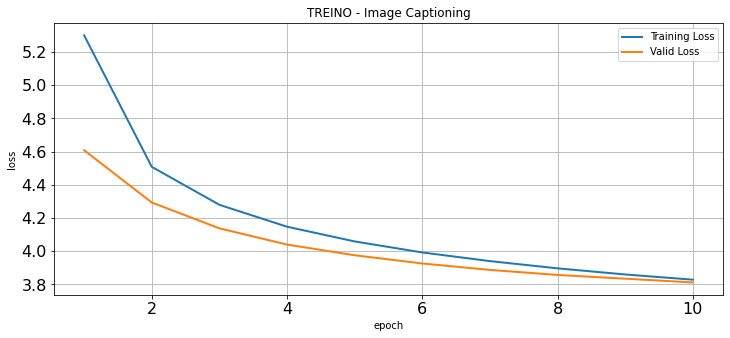

In [ ]:
df_stats[['Training Loss', 'Valid Loss']].plot(
    figsize=(12, 5), 
    lw=2, 
    ylabel="loss", 
    fontsize=16, 
    grid=True, 
    title='TREINO - Image Captioning'
    )

# Eval

In [ ]:
#================= Carrega os modelos =================#
encoder.load_state_dict(torch.load(config['enc_save_path']))
decoder.load_state_dict(torch.load(config['dec_save_path']))
encoder.eval()
decoder.eval()

result_collection = []

#================= Faz o decode =================#
with torch.no_grad():
    for batch_index, (inputs, captions) in enumerate(test_loader):
        inputs, captions = inputs.cuda(), captions.cuda()
        enc_out = encoder(inputs)
        out_gen = decoder.generate(src=enc_out, max_pred=20)
        result_caption = token_sentence(out_gen, itos)
        result_collection.extend(result_caption)
        print(batch_index, len(result_caption), result_caption)

0 32 ['a large white airplane is parked on a runway ', 'a large white truck is parked on the side of a street ', 'a large airplane is flying in the sky ', 'a dog is standing in a field ', 'a giraffe is eating from a tree ', 'a couple of men are standing in a car ', 'giraffe standing in a field ', 'a bird is standing on a bird sitting on a branch ', 'a dog is laying on a bed ', 'cat is sitting on top of a suitcase ', 'a horse standing in a field ', 'a group of elephants walking around a tree ', 'a boat is docked in the water ', 'a dog is laying on a bed ', 'a dog is laying on a bed ', 'a dog is standing on a leash on a leash ', 'a man is standing on a horse ', 'a man is standing next to a horse ', 'a man and a man and a dog ', 'a horse is standing in a field ', 'a close up of a car with a car with a car ', 'a man is eating a hot dog ', 'a cat is standing on a couch ', 'a cat is standing on a couch ', 'a man is riding a horse in a horse in a field ', 'a man is riding a horse on a horse '

## Para um predict 

		::: TRUE LABELS :::
['a group of boats sitting together with no one around',
 'a blue boat docked on a green lush shore.',
 'a  small marina with boats docked there',
 'boats sitting around the side of a lake by a tree',
 'some boats parked in the water at a dock']

PREDICT: 'a boat is docked in the water '


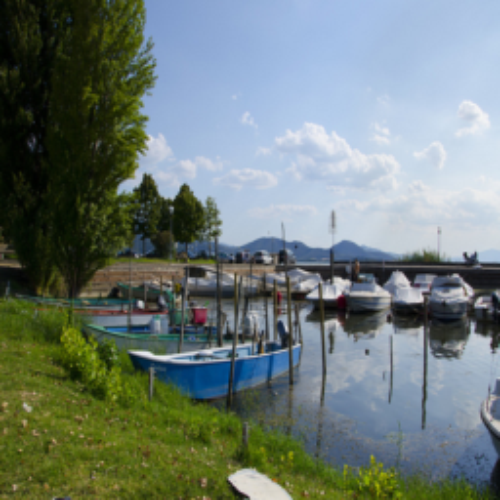

In [ ]:
#================= Gera um exemplo com TRUE-LABLES e PREDICT =================#
def get_sample_img(path_img, path_caption, random_sample=True, n=None):
    img_pil = transforms.ToPILImage()    
    img_tensor = transforms.ToTensor()
    img_resize = transforms.Resize(500)

    with open(path_caption, "rb") as handle:
        captions = json.loads(handle.read())

    ds = DataCaptioning(path_img, path_caption)
    if random_sample and n is None:
        picked = np.random.randint(0, len(ds))
        cap = captions[picked]
        cap = [s.lower() for s in cap]
        img, _ = ds[picked]
        predict = result_collection[picked]
    if n is not None:
        cap = captions[n]
        cap = [s.lower() for s in cap]
        img, _ = ds[n]
        predict = result_collection[n]
    
    print('\t\t===================')
    print('\t\t::: TRUE LABELS :::')
    print('\t\t===================')
    pprint.PrettyPrinter(indent=1, width=100).pprint(cap)
    
    print('\nPREDICT: ', end='')
    pprint.PrettyPrinter(indent=1, width=150).pprint(predict)

    img = img.numpy().transpose(1,2,0).astype(np.uint8)
    img = img_pil(img)
    return img_resize(img)


get_sample_img(test_path_imgs, test_path_captions, n=12)

### Calcula o Bleu Score para 1 predict 

In [ ]:
get_bleu_score(test_path_captions, picked=12)        

TRUE LABEL: a group of boats sitting together with no one around
PREDICT:    a boat is docked in the water   BLEU:  4.278

TRUE LABEL: a blue boat docked on a green lush shore.
PREDICT:    a boat is docked in the water   BLEU:  5.63

TRUE LABEL: a  small marina with boats docked there
PREDICT:    a boat is docked in the water   BLEU:  7.81

TRUE LABEL: boats sitting around the side of a lake by a tree
PREDICT:    a boat is docked in the water   BLEU:  4.41

TRUE LABEL: some boats parked in the water at a dock
PREDICT:    a boat is docked in the water   BLEU:  19.74



## Cálculo do bleu para todo o conj. de teste

In [ ]:
print(f'Blue total score: {get_bleu_teste_score(): .3}')

Blue total score:  12.3


# Fim